In [2]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#


# Design Optimization with Constraints


In the previous notebook we looked at various dipole variations, optimizing their design parameters to produce the lowest peak VSWR within our frequency range of interest.  In the final iteration (the "cage vee") we achieved a VSWR of less than 1.48 over the frequency range 3.5 - 3.7 MHz.
The total length of wire used was 79.71 meters (that's just for the half-dipole element we modeled).

Now we've become belatedly concerned with the cost of all that wire...

A simple single-wire inverted vee achieved a VSWR of 2.33 or less over the same band. If we can live with a VSWR of 2.0 or less over the band, we should be able to produce a design that uses a cage element for part of its length and a single wire for the remainder.

See below for our redefined Problem:  the objective we're minimizing is now total wire length, and "maximum VSWR less than 2.0" is now a constraint that a valid design must meet:


In [3]:

import numpy as np
from pymoo.core.problem import Problem
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, translate, make_cage_element, total_wire_len

#
# A new version of our base class that introduces constraints
#
class DipoleConstrainedSingleOptProblem(Problem):
    
    # Added 'n_ieq_constr' parameter: number of inequality constraints
    def __init__(self, n_var, n_ieq_constr, segs_per_m, radius, f_min, f_max, z, f_num=9, **kwargs):
        super().__init__(n_var=n_var,
                         n_obj=1,
                         n_ieq_constr=n_ieq_constr,
                         **kwargs)


        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC secgents per meter 
        self.radius = radius            # Wire radius (m)
        
        # NEC5 design deck template
        # GX: mirror across xz plane
        # EX: feedpoint specified as tag=1, segment=1, near end (1)
        # GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 
    def _make_nec5_design(self, design):
        nec_str = gen_nec5_str(design, self.segs_per_m, self.radius)        # Convert to a string of NEC cards
        return self.necpre + nec_str + self.necpost                         # Return as complete NEC deck


    # Evaluate the designs in X, an array of shape (population_size, number_of_variables)
    def _evaluate(self, X, out, *args, **kwargs):

        designs = [self._make_design(x) for x in X]                 # Make antenna designs based on params in X
        necdecks = [self._make_nec5_design(d) for d in designs]     # Convert to NEC decks (strings)

        res = nec5_sim_stdio3(necdecks, timelimit=10000.0)          # Run the simulations

        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Each row in 'vswr_curves' is the vswr curve across the band for one of the designs
        abs_refl_coef = np.abs((zs - self.z0) / (zs + self.z0))         # Reflection coefs
        vswr_curves = (1 + abs_refl_coef) / (1 - abs_refl_coef)         # Vswr
        max_vswr = np.max(vswr_curves, axis=1)[:,None]                  # Max vswr within band for each design (as column vector)

        # Provide _compute_objective() to calculate single objective to be minimize
        out["F"] = self._compute_objective(X, designs, zs, vswr_curves, max_vswr)

        # Provide _compute_constraints() to calculate one or more constraints (must be < 0 to meet constraint)
        out["G"] = self._compute_constraints(X, designs, zs, vswr_curves, max_vswr)

        # You can also attach other data to the population of designs
        # We'll save the vswr curves for each
        out["VSWR"] = vswr_curves





n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      200 |  0.000000E+00 |  4.1918151037 |  7.273057E+01 |  5.958577E+01
     2 |      300 |  0.000000E+00 |  1.2487094412 |  7.116102E+01 |  5.925496E+01
     3 |      400 |  0.000000E+00 |  0.5322960071 |  7.096532E+01 |  5.829460E+01
     4 |      500 |  0.000000E+00 |  0.2021414157 |  7.141774E+01 |  5.829460E+01
     5 |      600 |  0.000000E+00 |  0.0684365360 |  7.105555E+01 |  5.829460E+01
     6 |      700 |  0.000000E+00 |  0.0090404983 |  7.071129E+01 |  5.829460E+01
     7 |      800 |  0.000000E+00 |  0.000000E+00 |  6.973708E+01 |  5.786503E+01
     8 |      900 |  0.000000E+00 |  0.000000E+00 |  6.752252E+01 |  5.714669E+01
     9 |     1000 |  0.000000E+00 |  0.000000E+00 |  6.554091E+01 |  5.714669E+01
    10 |     1100 |  0.000000E+00 |  0.000000E+00 |  6.432488E+01 |  5.687871E+01
    11 |     1200 |  0.000000E+00 |  0.000000E+00 |  6.305426E+01 |  5.687871E+01
    12 |     130

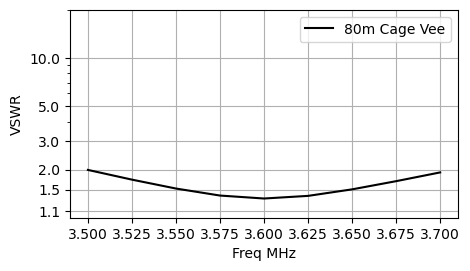

In [5]:
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.ga import GA


#
# As before, you need to write your own _make_design() method to implement your design's geometry
#
# Also moved computation of objective (minimize wire length) and constraint (VSWR < 2.0)
#  into their own methods _compute_objective() and _compute_constraints()
#
AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element

class MinWireCageVeeProblem(DipoleConstrainedSingleOptProblem):
    
    # Design params: 
    #   x[0]    overall length
    #   x[1]    vee angle
    #   x[2]    length of 'cage' portion as fraction of overall length
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))
        half_el.extend( make_cage_element(0.5, x[0]*x[2]+0.5, .2, .5, 4) )
        half_el.extend( make_linear_element((0,x[0]*x[2]+0.5,0),(0,x[0],0)) )
        half_el = rot_x(half_el, np.deg2rad(x[1]))
        half_el = translate(half_el, (0,0,self.z))
        return half_el

    # Objective to minimize: total wire length
    # Sum total wire length for each design, return as column vector
    def _compute_objective(self, X, designs, zs, vswr_curves, max_vswr):
        return np.array([ total_wire_len(design) for design in designs ])[:,None]
        
    # Constraint: max VSWR must be < 2.0 across freq range
    #  (constraint val must be < 0)
    def _compute_constraints(self, X, designs, zs, vswr_curves, max_vswr):
        return (max_vswr - 2.0)


mwcvproblem = MinWireCageVeeProblem(n_var=3, n_ieq_constr=1, f_min=3.5, f_max=3.7, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([20.0, -45, 0.1]),
                                xu=np.array([26.0, 0, 1.0]))
termination = get_termination("n_gen", 50)
algorithm = GA(pop_size=200, n_offsprings=100)

res = minimize(mwcvproblem, algorithm, termination, save_history=False, verbose=True)

print(f'Optimum length {res.X[0]:.1f}m, angle {res.X[1]:.1f}deg, cage fraction {res.X[2]:.2f}, wire length {res.F[0]:.2f}')
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(mwcvproblem.freqs, vswr_curve)], tags=['80m Cage Vee'])

design = mwcvproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45))


Result:  total wire length 46.44m versus 79.71m for original design.
![Graph](img/CageVee2_opt.png)